# Relax Inc Data Science Takehome Challenge

In [87]:
# importing libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style = 'darkgrid')
import datetime 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,ConfusionMatrixDisplay,f1_score, precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance


___

## 1 Loading Data

In [2]:
# loading data
df_engagement = pd.read_csv('takehome_user_engagement.csv', parse_dates=True)
df_users = pd.read_csv('takehome_users.csv',encoding='latin-1', parse_dates=True)

___

## 2 Data Exploration

### 2.1 df_engagement

In [3]:
df_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
df_engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


No missing data in df_engagement which good news. We will change 'time_stamp' to a DateTime object though.

### 2.2 df_users

In [5]:
df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [6]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


df_users contains missing values:</br> </br>
<b>'invited_by_user_id'</b> has which user invited them as input, if applicable. Meaning missing values are those users who weren't invited by another user.</br></br>
<b>'last_session_creation_time'</b> is the last login time. We are assuming this is missing because a user never logged in. Also, this column is a unix timestamp, we will need to convert it to a regular timestamp for better interpretability.

___

## 3 Data Wrangling

### 3.1 Converting 'last_session_creation_time' from Unix to Standard DateTime 

In [7]:
df_users['last_session_creation_time'] = df_users['last_session_creation_time'].fillna(value = 0)
df_users['last_session_creation_time'] = df_users['last_session_creation_time'].apply\
(lambda x: datetime.datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))

### 3.2  Creating 'df_active_users'
This data frame will only contain the 8823 users who have at least one login in the 'df_users' data frame. 

In [8]:
df_active_users = df_users[df_users['last_session_creation_time']!= '1970-01-01 00:00:00']

In [9]:
df_active_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0


In [10]:
# checking for and unique user ids
df_active_users['object_id'].nunique()

8823

In [11]:
# checking for duplicates
df_active_users.duplicated().sum()

0

In [12]:
df_active_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   8823 non-null   int64  
 1   creation_time               8823 non-null   object 
 2   name                        8823 non-null   object 
 3   email                       8823 non-null   object 
 4   creation_source             8823 non-null   object 
 5   last_session_creation_time  8823 non-null   object 
 6   opted_in_to_mailing_list    8823 non-null   int64  
 7   enabled_for_marketing_drip  8823 non-null   int64  
 8   org_id                      8823 non-null   int64  
 9   invited_by_user_id          4776 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 758.2+ KB


### 3.3 Replacing 'invited_by_user_id' with a Boolean Column
We will replace 'invited_by_user_id' with a boolean column that will convey whether a user was invited or not.

In [13]:
df_active_users.invited_by_user_id.fillna(value = 0, inplace = True)

/var/folders/83/dz7v902j3fd30yf52s_ffc5m0000gn/T/ipykernel_52009/2297385058.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_active_users.invited_by_user_id.fillna(value = 0, inplace = True)


In [14]:
df_active_users['invited_by_user'] = df_active_users.invited_by_user_id.apply(lambda x: 1 if x != 0 else 0)

/var/folders/83/dz7v902j3fd30yf52s_ffc5m0000gn/T/ipykernel_52009/2988629060.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_active_users['invited_by_user'] = df_active_users.invited_by_user_id.apply(lambda x: 1 if x != 0 else 0)


### 3.4 Creating a Coulmn for Target Variable
The target variable is whether a use has been adopted or not. "adopted user" is a user who has logged into the product on three separate days in at least one seven day period. 

In [15]:
# checking if our assumption about the active users was correct, it is
df_engagement['user_id'].nunique()

8823

In [16]:
# converting 'time_stamp' to datetime 
df_engagement['time_stamp'] = pd.to_datetime(df_engagement['time_stamp'])

In [17]:
# creating 'date' column
df_engagement['date'] = df_engagement['time_stamp'].dt.date

In [18]:
df_engagement.head()

,time_stamp,user_id,visited,date
0,2014-04-22 03:53:30,1,1,2014-04-22
1,2013-11-15 03:45:04,2,1,2013-11-15
2,2013-11-29 03:45:04,2,1,2013-11-29
3,2013-12-09 03:45:04,2,1,2013-12-09
4,2013-12-25 03:45:04,2,1,2013-12-25


In [19]:
# create function to calculate an adopted user 

def login_freq(df):
    # drop duplicate days, sort by date 
    df = df.drop_duplicates(subset='date').sort_values('date')
    # get the difference of days covering 3 logins
    day_diff = df['date'].diff(2)
    # return True if any 3 day login-span is within a 7 day period
    return any(day_diff <= datetime.timedelta(days=7))

In [20]:
# apply extraction fucntion to the dataframe 
adopted = df_engagement.groupby('user_id').apply(login_freq)

# create new dataframe with properly named columns
adopted_df = pd.DataFrame(adopted, columns=['adopted'])

#convert boolean adoption column into 1/0 numeric values 
adopted_df['adopted'] = adopted_df.adopted.astype('int')

# 'user_id' its own column
adopted_df.index.name = 'user_id'

# reset the index
adopted_df.reset_index(inplace=True)

In [21]:
adopted_df.head()

,user_id,adopted
0,1,0
1,2,1
2,3,0
3,4,0
4,5,0


In [22]:
adopted_df.adopted.value_counts()

0    7167
1    1656
Name: adopted, dtype: int64

There are 1656 users who are considered adopted, and 7167 who are not.

In [23]:
# create dataframe with sum of visits for each user 
user_visits = df_engagement.groupby('user_id').sum('visited')
user_visits.index.name = 'user_id'
user_visits.reset_index(inplace=True)
user_visits.rename(columns={'visited':'visits'}, inplace=True)

# join user visit count to 'adopted' dataframe 
adopted_df = adopted_df.merge(user_visits, how='inner')

In [24]:
adopted_df.head()

,user_id,adopted,visits
0,1,0,1
1,2,1,14
2,3,0,1
3,4,0,1
4,5,0,1


In [25]:
df_active_users = df_active_users.rename(columns = {'object_id':'user_id'})
df_active_users_2 = pd.merge(df_active_users, adopted_df, on = 'user_id',how='left' )
df_active_users_2 = df_active_users_2.drop(columns=['invited_by_user_id','email','name'])

### 3.5 Creating Column for Account Age

In [26]:
df_active_users_2.last_session_creation_time = pd.to_datetime(df_active_users_2.last_session_creation_time)
df_active_users_2.creation_time = pd.to_datetime(df_active_users_2.creation_time)


In [27]:
# create column that represents the age of the account in days: last login date - account creation date 
df_active_users_2['account_age'] = df_active_users_2.last_session_creation_time - df_active_users_2.creation_time

# convert that column from timedelta to integer 
df_active_users_2.account_age = df_active_users_2['account_age'].dt.days.astype('int')

In [28]:
df_active_users_2.org_id = df_active_users_2.org_id.astype(str)

In [29]:
df_active_users_3 = pd.get_dummies(df_active_users_2, columns = ['creation_source'] )

In [30]:
df_active_users_2.head()

,user_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user,adopted,visits,account_age
0,1,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,1,0,1,0
1,2,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,1,1,1,14,136
2,3,2013-03-19 23:14:52,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1,0,1,0
3,4,2013-05-21 08:09:28,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,1,0,1,1
4,5,2013-01-17 10:14:20,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,1,0,1,5


In [31]:
df_active_users_3.head()

,user_id,creation_time,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user,adopted,visits,account_age,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,2014-04-22 03:53:30,2014-04-22 03:53:30,1,0,11,1,0,1,0,1,0,0,0,0
1,2,2013-11-15 03:45:04,2014-03-31 03:45:04,0,0,1,1,1,14,136,0,1,0,0,0
2,3,2013-03-19 23:14:52,2013-03-19 23:14:52,0,0,94,1,0,1,0,0,1,0,0,0
3,4,2013-05-21 08:09:28,2013-05-22 08:09:28,0,0,1,1,0,1,1,1,0,0,0,0
4,5,2013-01-17 10:14:20,2013-01-22 10:14:20,0,0,193,1,0,1,5,1,0,0,0,0


In [32]:
df_active_users_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 8822
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     8823 non-null   int64         
 1   creation_time               8823 non-null   datetime64[ns]
 2   creation_source             8823 non-null   object        
 3   last_session_creation_time  8823 non-null   datetime64[ns]
 4   opted_in_to_mailing_list    8823 non-null   int64         
 5   enabled_for_marketing_drip  8823 non-null   int64         
 6   org_id                      8823 non-null   object        
 7   invited_by_user             8823 non-null   int64         
 8   adopted                     8823 non-null   int64         
 9   visits                      8823 non-null   int64         
 10  account_age                 8823 non-null   int64         
dtypes: datetime64[ns](2), int64(7), object(2)
memory usage: 

___

## 4 EDA

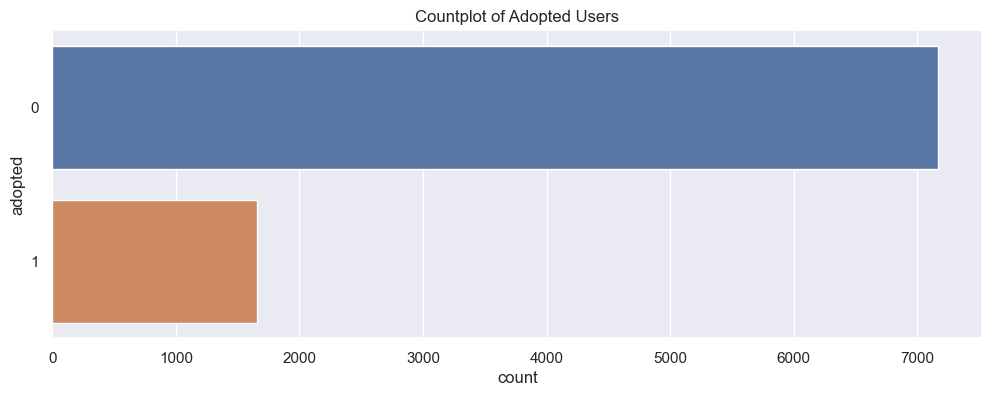

In [33]:
plt.figure(figsize=(12,4))
plt.title('Countplot of Adopted Users')
sns.countplot(y = 'adopted', data = df_active_users_2);

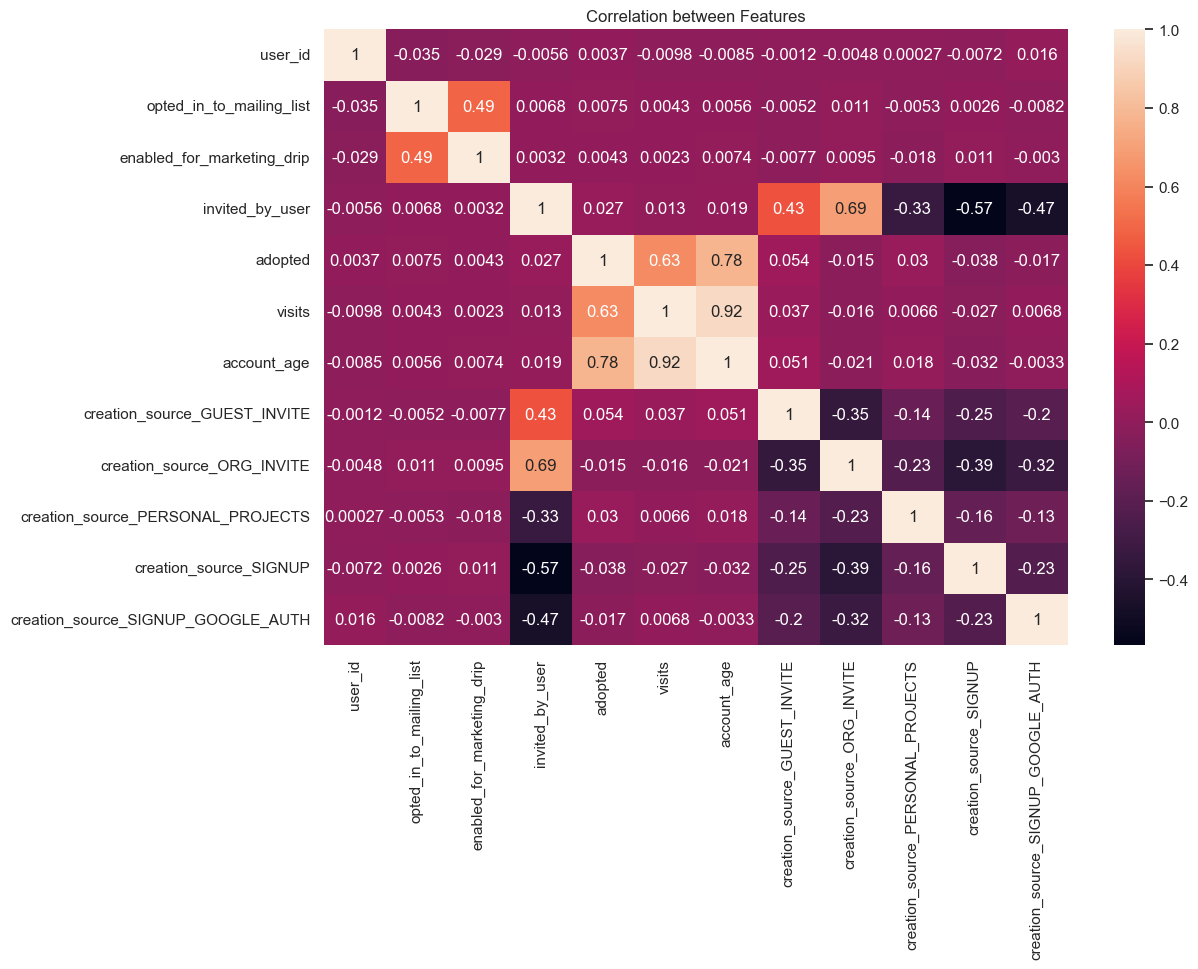

In [34]:
plt.figure(figsize = (12,8))
plt.title('Correlation between Features')
sns.heatmap(df_active_users_3.corr(numeric_only=True), annot=True);

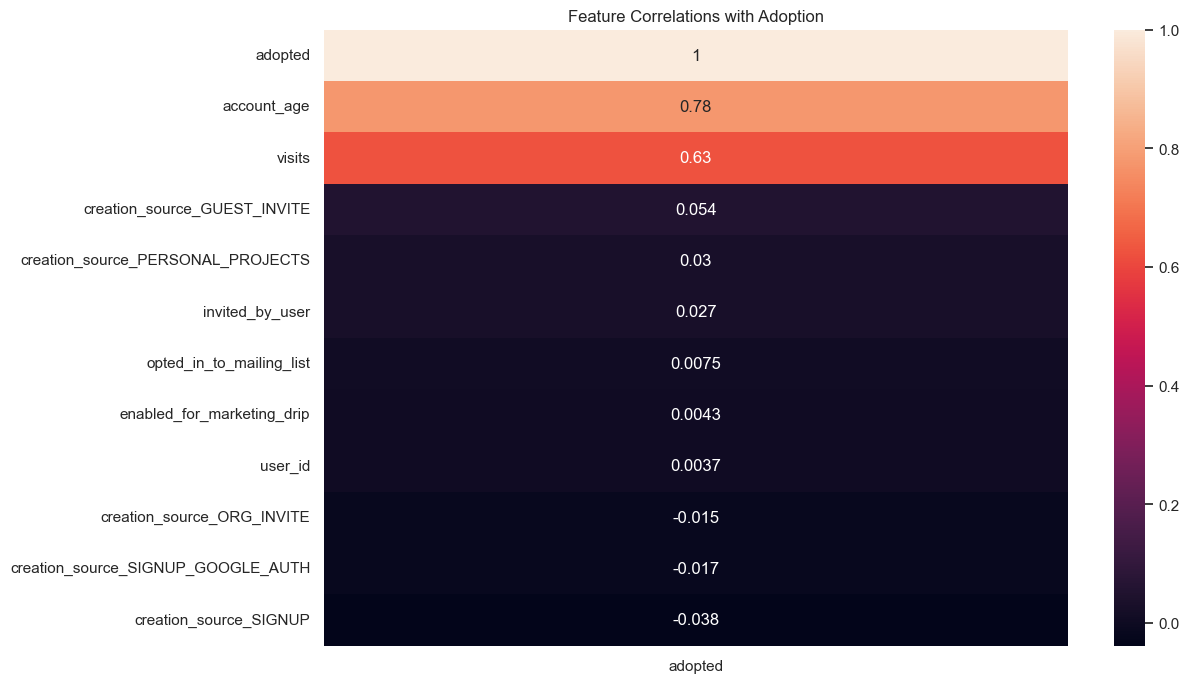

In [35]:
plt.figure(figsize = (12,8))
plt.title('Feature Correlations with Adoption')
sns.heatmap(df_active_users_3.corr(numeric_only=True)[['adopted']].sort_values(by = 'adopted',ascending = False), annot=True);

There are two features that are highly correlated with user adoption. Account age is highly correlated with adoption, this is probably because the longer a user uses their account the more likely they'd use the account 3 times in a 7 day duration. The number of visits is correlated with adoption as well, which makes sense because adoption is calculated based on the number of visits within a 7 day period.

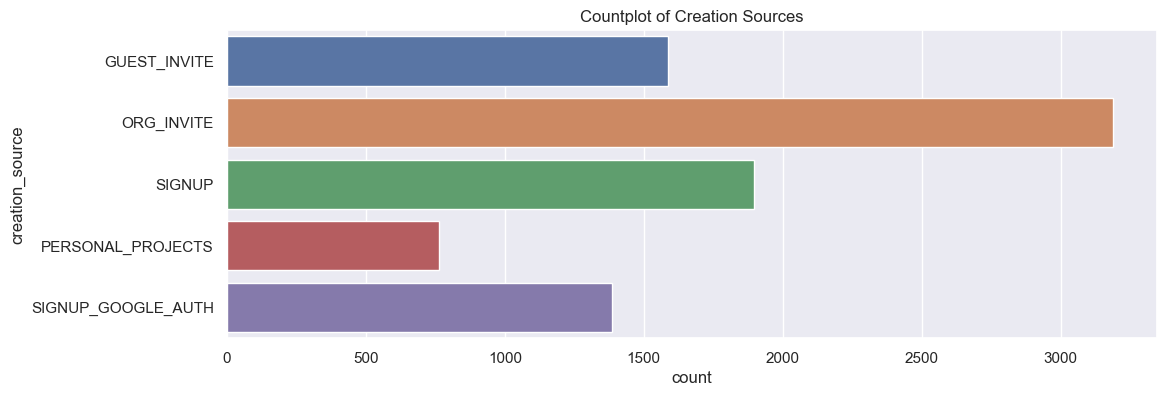

In [36]:
plt.figure(figsize=(12,4))
plt.title('Countplot of Creation Sources')
sns.countplot(y = 'creation_source', data = df_active_users_2);

___

## 5 Preprocessing and Modeling Using Random Forest Classifier

In [42]:
df_active_users_2.creation_time = df_active_users_2.creation_time.dt.year
df_active_users_2.last_session_creation_time = df_active_users_2.last_session_creation_time.dt.year

In [43]:
final_df = pd.get_dummies(df_active_users_2, columns=['org_id','creation_source','creation_time','last_session_creation_time'])

In [45]:
final_df = final_df.drop(columns=['user_id'], axis = 1)

In [46]:
final_df.columns

Index(['opted_in_to_mailing_list', 'enabled_for_marketing_drip',
       'invited_by_user', 'adopted', 'visits', 'account_age', 'org_id_0',
       'org_id_1', 'org_id_10', 'org_id_100',
       ...
       'creation_source_ORG_INVITE', 'creation_source_PERSONAL_PROJECTS',
       'creation_source_SIGNUP', 'creation_source_SIGNUP_GOOGLE_AUTH',
       'creation_time_2012', 'creation_time_2013', 'creation_time_2014',
       'last_session_creation_time_2012', 'last_session_creation_time_2013',
       'last_session_creation_time_2014'],
      dtype='object', length=434)

In [47]:
# X and y split: 
X = final_df.drop(columns=['adopted'], axis = 1)
y = final_df['adopted']

In [50]:
# train/test split the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=42)

In [51]:
# scaling features
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [80]:
param_grid = {'bootstrap': [True, False],
        'max_depth': [10, 15, 20, 25, 30],
        'max_features': ['sqrt'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [25, 50, 75, 100, 150]}

rf = RandomForestClassifier()
grid_model = RandomizedSearchCV(rf, param_distributions=param_grid, cv=5, verbose=True, random_state=13)


In [81]:
grid_model.fit(scaled_X_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 15, 20, 25, 30],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [25, 50, 75, 100, 150]},
                   random_state=13, verbose=True)

In [82]:
print(f'Best parameters: {grid_model.best_params_}')
print(f'Training accuracy score from tuned model: {grid_model.best_score_*100:.1f}%')
print('')

Best parameters: {'n_estimators': 75, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}
Training accuracy score from tuned model: 97.8%



In [83]:
# create function that prints evaluation scores
def evaluate(y__test, y__pred):
    ac = accuracy_score(y__test, y__pred)
    f1 = f1_score(y__test, y__pred, average='binary')
    pr = precision_score(y__test, y__pred, average='binary')
    re = recall_score(y__test, y__pred, average='binary')

    print('Accuracy Score = %.3f' % (ac))
    print('F1 Score = %.3f' % (f1))
    print("Precision = {}".format(round(pr, 3)))
    print("Recall = {}".format(round(re, 3)))


In [85]:
y_pred = grid_model.predict(scaled_X_test)

In [88]:
# generate accuracy scores
evaluate(y_test, y_pred)

Accuracy Score = 0.977
F1 Score = 0.941
Precision = 0.945
Recall = 0.937


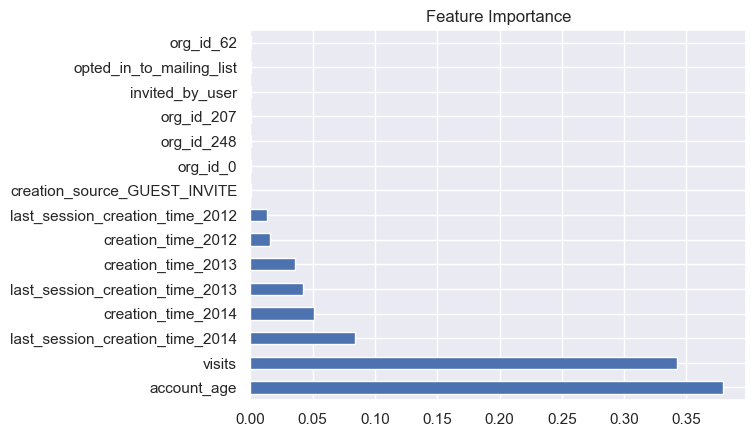

In [97]:
feat_importances = pd.Series(grid_model.best_estimator_.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh', title = 'Feature Importance');

___

## 6 Conclusion

The Random Forest Classifier that we built was able to perform well. But, the only features that provided any predictive value were those that were time-related: Account age, session creation time, number of visits, and last session creation time. The problem with this is that it doesn't provide value for predicting whether a new user is going to be adopted or not, because we're only looking at features that describe a user retrospectively to tell us if a user is going to be obtained or not. This is not a good approach because those predictive features are closely related to our target feature. Essentially they are measuring very similar things, and because of that won't provide a lot of value.

___